# 学習の可視化
## TensorFlowによる実装

In [1]:
import numpy as np
import tensorflow as tf
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

np.random.seed(0)
tf.set_random_seed(1234)


def inference(x, keep_prob, n_in, n_hiddens, n_out):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)

    def bias_variable(shape):
        initial = tf.zeros(shape)
        return tf.Variable(initial)

    # 入力層 - 隠れ層、隠れ層 - 隠れ層
    for i, n_hidden in enumerate(n_hiddens):
        if i == 0:
            input = x
            input_dim = n_in
        else:
            input = output
            input_dim = n_hiddens[i-1]

        W = weight_variable([input_dim, n_hidden])
        b = bias_variable([n_hidden])

        h = tf.nn.relu(tf.matmul(input, W) + b)
        output = tf.nn.dropout(h, keep_prob)

    # 隠れ層 - 出力層
    W_out = weight_variable([n_hiddens[-1], n_out])
    b_out = bias_variable([n_out])
    y = tf.nn.softmax(tf.matmul(output, W_out) + b_out)
    return y


def loss(y, t):
    cross_entropy = \
        tf.reduce_mean(-tf.reduce_sum(
                       t * tf.log(tf.clip_by_value(y, 1e-10, 1.0)),
                       axis=1))
    return cross_entropy


def training(loss):
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train_step = optimizer.minimize(loss)
    return train_step


def accuracy(y, t):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy


if __name__ == '__main__':
    '''
    データの生成
    '''
    mnist = datasets.fetch_mldata('MNIST original', data_home='.')

    n = len(mnist.data)
    N = 30000  # MNISTの一部を使う
    N_train = 20000
    N_validation = 4000
    indices = np.random.permutation(range(n))[:N]  # ランダムにN枚を選択

    X = mnist.data[indices]
    y = mnist.target[indices]
    Y = np.eye(10)[y.astype(int)]  # 1-of-K 表現に変換

    X_train, X_test, Y_train, Y_test = \
        train_test_split(X, Y, train_size=N_train)

    X_train, X_validation, Y_train, Y_validation = \
        train_test_split(X_train, Y_train, test_size=N_validation)

    '''
    モデル設定
    '''
    n_in = len(X[0])
    n_hiddens = [200, 200, 200]  # 各隠れ層の次元数
    n_out = len(Y[0])
    p_keep = 0.5

    x = tf.placeholder(tf.float32, shape=[None, n_in])
    t = tf.placeholder(tf.float32, shape=[None, n_out])
    keep_prob = tf.placeholder(tf.float32)

    y = inference(x, keep_prob, n_in=n_in, n_hiddens=n_hiddens, n_out=n_out)
    loss = loss(y, t)
    train_step = training(loss)

    accuracy = accuracy(y, t)

    history = {
        'val_loss': [],
        'val_acc': []
    }

    '''
    モデル学習
    '''
    epochs = 50
    batch_size = 200

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    n_batches = N_train // batch_size

    for epoch in range(epochs):
        X_, Y_ = shuffle(X_train, Y_train)

        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size

            sess.run(train_step, feed_dict={
                x: X_[start:end],
                t: Y_[start:end],
                keep_prob: p_keep
            })

        # 検証データを用いた評価
        val_loss = loss.eval(session=sess, feed_dict={
            x: X_validation,
            t: Y_validation,
            keep_prob: 1.0
        })
        val_acc = accuracy.eval(session=sess, feed_dict={
            x: X_validation,
            t: Y_validation,
            keep_prob: 1.0
        })

        # 検証データに対する学習の進み具合を記録
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print('epoch:', epoch,
              ' validation loss:', val_loss,
              ' validation accuracy:', val_acc)

    '''
    学習の進み具合を可視化
    '''
    plt.rc('font', family='serif')
    fig = plt.figure()
    ax_acc = fig.add_subplot(111)
    ax_acc.plot(range(epochs), history['val_acc'],
                label='acc', color='black')
    ax_loss = ax_acc.twinx()
    ax_loss.plot(range(epochs), history['val_loss'],
                 label='loss', color='gray')
    plt.xlabel('epochs')
    # plt.show()
    plt.savefig('mnist_tensorflow.eps')

    '''
    予測精度の評価
    '''
    accuracy_rate = accuracy.eval(session=sess, feed_dict={
        x: X_test,
        t: Y_test,
        keep_prob: 1.0
    })
    print('accuracy: ', accuracy_rate)

/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


epoch: 0  validation loss: 2.1558669  validation accuracy: 0.26725
epoch: 1  validation loss: 0.8131207  validation accuracy: 0.768
epoch: 2  validation loss: 0.51363796  validation accuracy: 0.85125
epoch: 3  validation loss: 0.40519613  validation accuracy: 0.88725
epoch: 4  validation loss: 0.3408817  validation accuracy: 0.90225
epoch: 5  validation loss: 0.30277404  validation accuracy: 0.914
epoch: 6  validation loss: 0.26965433  validation accuracy: 0.92175
epoch: 7  validation loss: 0.25186813  validation accuracy: 0.9305
epoch: 8  validation loss: 0.23474042  validation accuracy: 0.93325
epoch: 9  validation loss: 0.22533228  validation accuracy: 0.9335
epoch: 10  validation loss: 0.21379852  validation accuracy: 0.93875
epoch: 11  validation loss: 0.20155106  validation accuracy: 0.94375
epoch: 12  validation loss: 0.20540118  validation accuracy: 0.94075
epoch: 13  validation loss: 0.18442798  validation accuracy: 0.948
epoch: 14  validation loss: 0.19221994  validation accu

## Kerasによる実装

Using TensorFlow backend.
/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train on 16000 samples, validate on 4000 samples
Epoch 1/50
16000/16000 [==============================] - 1s 89us/step - loss: 2.2604 - acc: 0.1546 - val_loss: 2.0650 - val_acc: 0.4370
Epoch 2/50
16000/16000 [==============================] - 1s 63us/step - loss: 1.4282 - acc: 0.5261 - val_loss: 0.7209 - val_acc: 0.7718
Epoch 3/50
16000/16000 [==============================] - 1s 78us/step - loss: 0.8070 - acc: 0.7351 - val_loss: 0.4907 - val_acc: 0.8597
Epoch 4/50
16000/16000 [==============================] - 1s 61us/step - loss: 0.6134 - acc: 0.8109 - val_loss: 0.3994 - val_acc: 0.8833
Epoch 5/50
16000/16000 [==============================] - 1s 52us/step - loss: 0.5117 - acc: 0.8460 - val_loss: 0.3328 - val_acc: 0.9043
Epoch 6/50
16000/16000 [==============================] - 1s 56us/step - loss: 0.4365 - acc: 0.8709 - val_loss: 0.2996 - val_acc: 0.9110
Epoch 7/50
16000/16000 [==============================] - 1s 60us/step - loss: 0.3893 - acc: 0.8867 - val_loss: 0.2586 - val_acc:

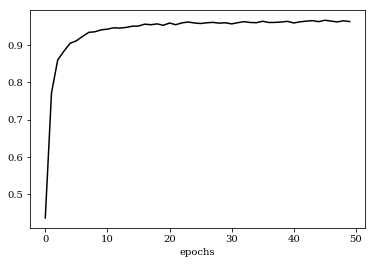

10000/10000 [==============================] - 0s 38us/step
[0.13572957476451994, 0.9665]


In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras import backend as K
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(123)

'''
データの生成
'''
mnist = datasets.fetch_mldata('MNIST original', data_home='.')

n = len(mnist.data)
N = 30000  # MNISTの一部を使う
N_train = 20000
N_validation = 4000
indices = np.random.permutation(range(n))[:N]  # ランダムにN枚を選択

X = mnist.data[indices]
y = mnist.target[indices]
Y = np.eye(10)[y.astype(int)]

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, Y, train_size=N_train)
X_train, X_validation, Y_train, Y_validation = \
    train_test_split(X_train, Y_train, test_size=N_validation)

'''
モデル設定
'''
n_in = len(X[0])  # 784
n_hiddens = [200, 200, 200]
n_out = len(Y[0])  # 10
p_keep = 0.5
activation = 'relu'


def weight_variable(shape):
    return K.truncated_normal(shape, stddev=0.01)
    # return np.random.normal(scale=0.01, size=shape)


model = Sequential()
for i, input_dim in enumerate(([n_in] + n_hiddens)[:-1]):
    model.add(Dense(n_hiddens[i], input_dim=input_dim,
                    kernel_initializer=weight_variable))
    model.add(Activation(activation))
    model.add(Dropout(p_keep))

model.add(Dense(n_out, kernel_initializer=weight_variable))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])

'''
モデル学習
'''
epochs = 50
batch_size = 200

hist = model.fit(X_train, Y_train, epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(X_validation, Y_validation))

'''
学習の進み具合を可視化
'''
val_acc = hist.history['val_acc']
val_loss = hist.history['val_loss']

plt.rc('font', family='serif')
fig = plt.figure()
plt.plot(range(epochs), val_acc, label='acc', color='black')
plt.xlabel('epochs')
plt.show()
# plt.savefig('mnist_keras.eps')

'''
予測精度の評価
'''
loss_and_metrics = model.evaluate(X_test, Y_test)
print(loss_and_metrics)